In [23]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [24]:
train = pd.read_csv("train.csv")
train

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [26]:
train.loc[:, ~train.columns.isin(["PassengerId"])].select_dtypes(exclude=["object"]).corr()["Survived"].sort_values(ascending=False)

Survived    1.000000
Fare        0.257307
Parch       0.081629
SibSp      -0.035322
Age        -0.077221
Pclass     -0.338481
Name: Survived, dtype: float64

# Идеи для анализа

1. Анализ возраста (подстановка - но использовать не среднее/мода/медиана, а небольшой разброс с неким шагом относительно моды в +- в случайном порядке - чтобы в распределении не вычленять одно значение; либо проанализировать имеющиеся диапазоны - страты - их процентное соотношение и в зависимости от соотношения "разбрасывать" их в пропущенных данных)
2. Анализ кабин (группировка в зависимости от расположения - верхняя палуба, дальние комнаты - в категории (условно по 20-50 комнат); но это, если есть взаимосвязь между расположением комнаты и выживаемостью)
3. Анализ родственных связей (группировка при кодировании в зависимости от выживаемости + ВОЗМОЖНО, построение новых признаков - если есть взаимосвязь между связями с родителями и детьми у человека с точки зрения выживаемости)

- Анализ пола: соотношение выживших/погибших среди мужчин и среди женщин - выживаемость человека с каким полом вероятнее?

### Анализ возраста

Имеется зависимость: наибольшая выживаемость наблюдается у детей, наибольшая смертность - у молодых людей от $15$ до $35$ лет. В отрыве от остальных признаков неочевидна причина (действительно ли это паттерн или есть связь с другими признаками. 

**Первичное решение**: Группировка непрерывной переменной *Age* на диапазоны примерно по $10$ лет ($\{0, 10\}, \{11, 20\}, \dots, \{71, 80\}$) (выбор такого шага - первое, что приходит в голову, но также появляется наглядность распределения и достигается максимальное значение коэффициента Пирсона на целевую переменную).

(0.34, 8.378]        54
(8.378, 16.336]      46
(16.336, 24.294]    177
(24.294, 32.252]    169
(32.252, 40.21]     118
(40.21, 48.168]      70
(48.168, 56.126]     45
(56.126, 64.084]     24
(64.084, 72.042]      9
(72.042, 80.0]        2
Name: cat. Age, dtype: int64


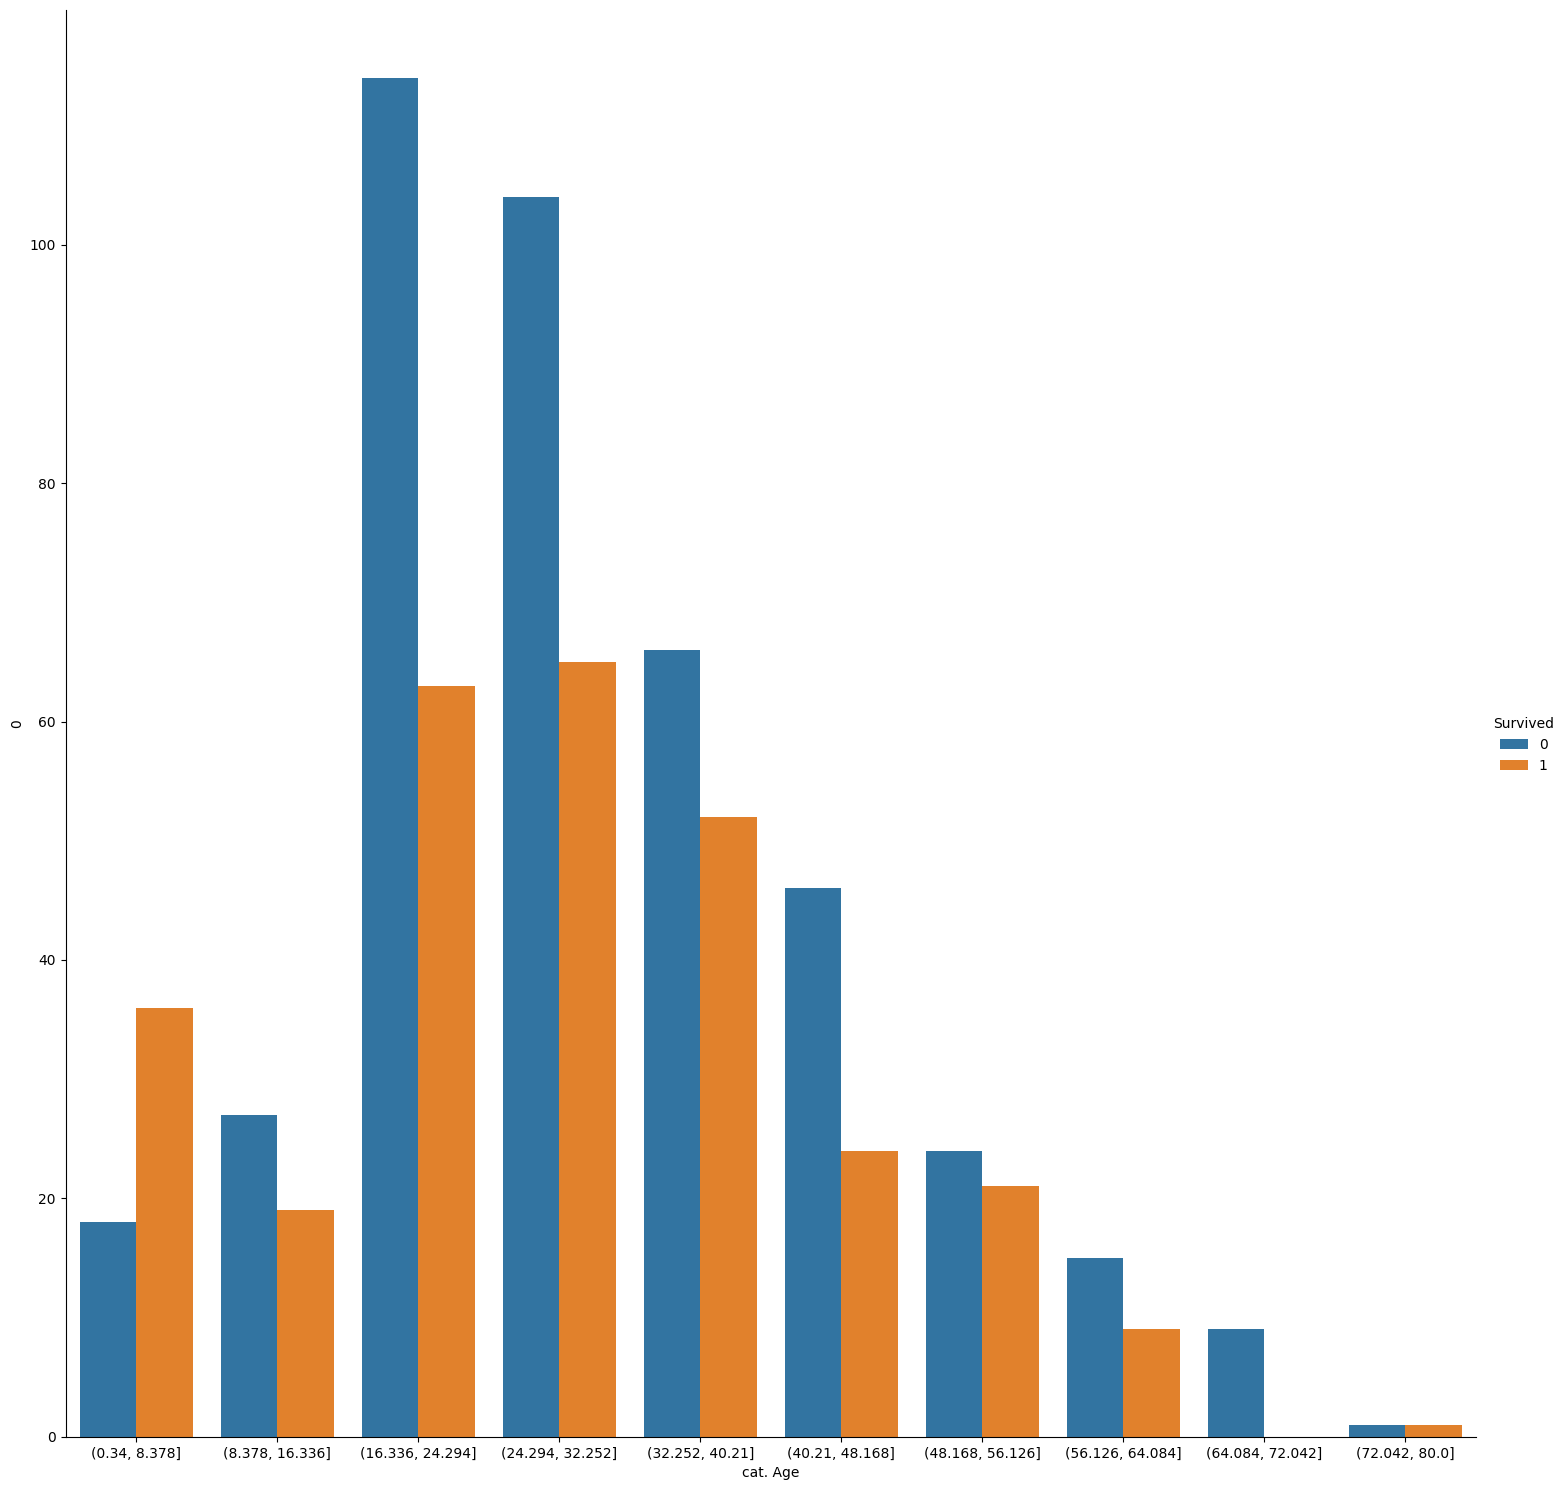

In [27]:
# Максимальный коэффициент Пирсона (-0.05203642485589537) при q = 14
# train["cat. Age"] = pd.qcut(train.Age, q=14, labels=False)

# Максимальный коэффициент Пирсона (-0.08035460072924827) при q = 10
train["cat. Age"] = pd.cut(train.Age, bins=10)
print(train["cat. Age"].value_counts().sort_index())

group_age = train[["cat. Age", "Survived"]].groupby(by="cat. Age").value_counts().reset_index()
group_age

'''corr = train.loc[:, ~train.columns.isin(["PassengerId"])]\
    .select_dtypes(exclude=["object"])\
    .corr()["Survived"]\
    .sort_values(ascending=False)
print(corr["cat. Age"])'''

sns.catplot(
    data=group_age,
    x="cat. Age",
    y=0,
    hue="Survived",
    kind="bar",
    height=15,
    aspect=1)

### Анализ кабин

**Идея**: Анализ кабин (группировка в зависимости от расположения - верхняя палуба, дальние комнаты - в категории (условно по 20-50 комнат); но это, если есть взаимосвязь между расположением комнаты и выживаемостью)

**Факты**
* Каюты первого класса размещались на палубах от A до Е
* Каюты второго класса размещались на палубах от D до G
* Каюты третьего класса размещались на палубах от D до G

...\
**Предварительное решение**: прямой зависимости не наблюдается (коэффициент Пирсона незначителен), вдобавок, так как проводилась эвакуация пассажиров, то принцип "Сначала женщин и детей" нивелирует расположение кают (возможны отдельные незначительные связи, но они не так значимы).

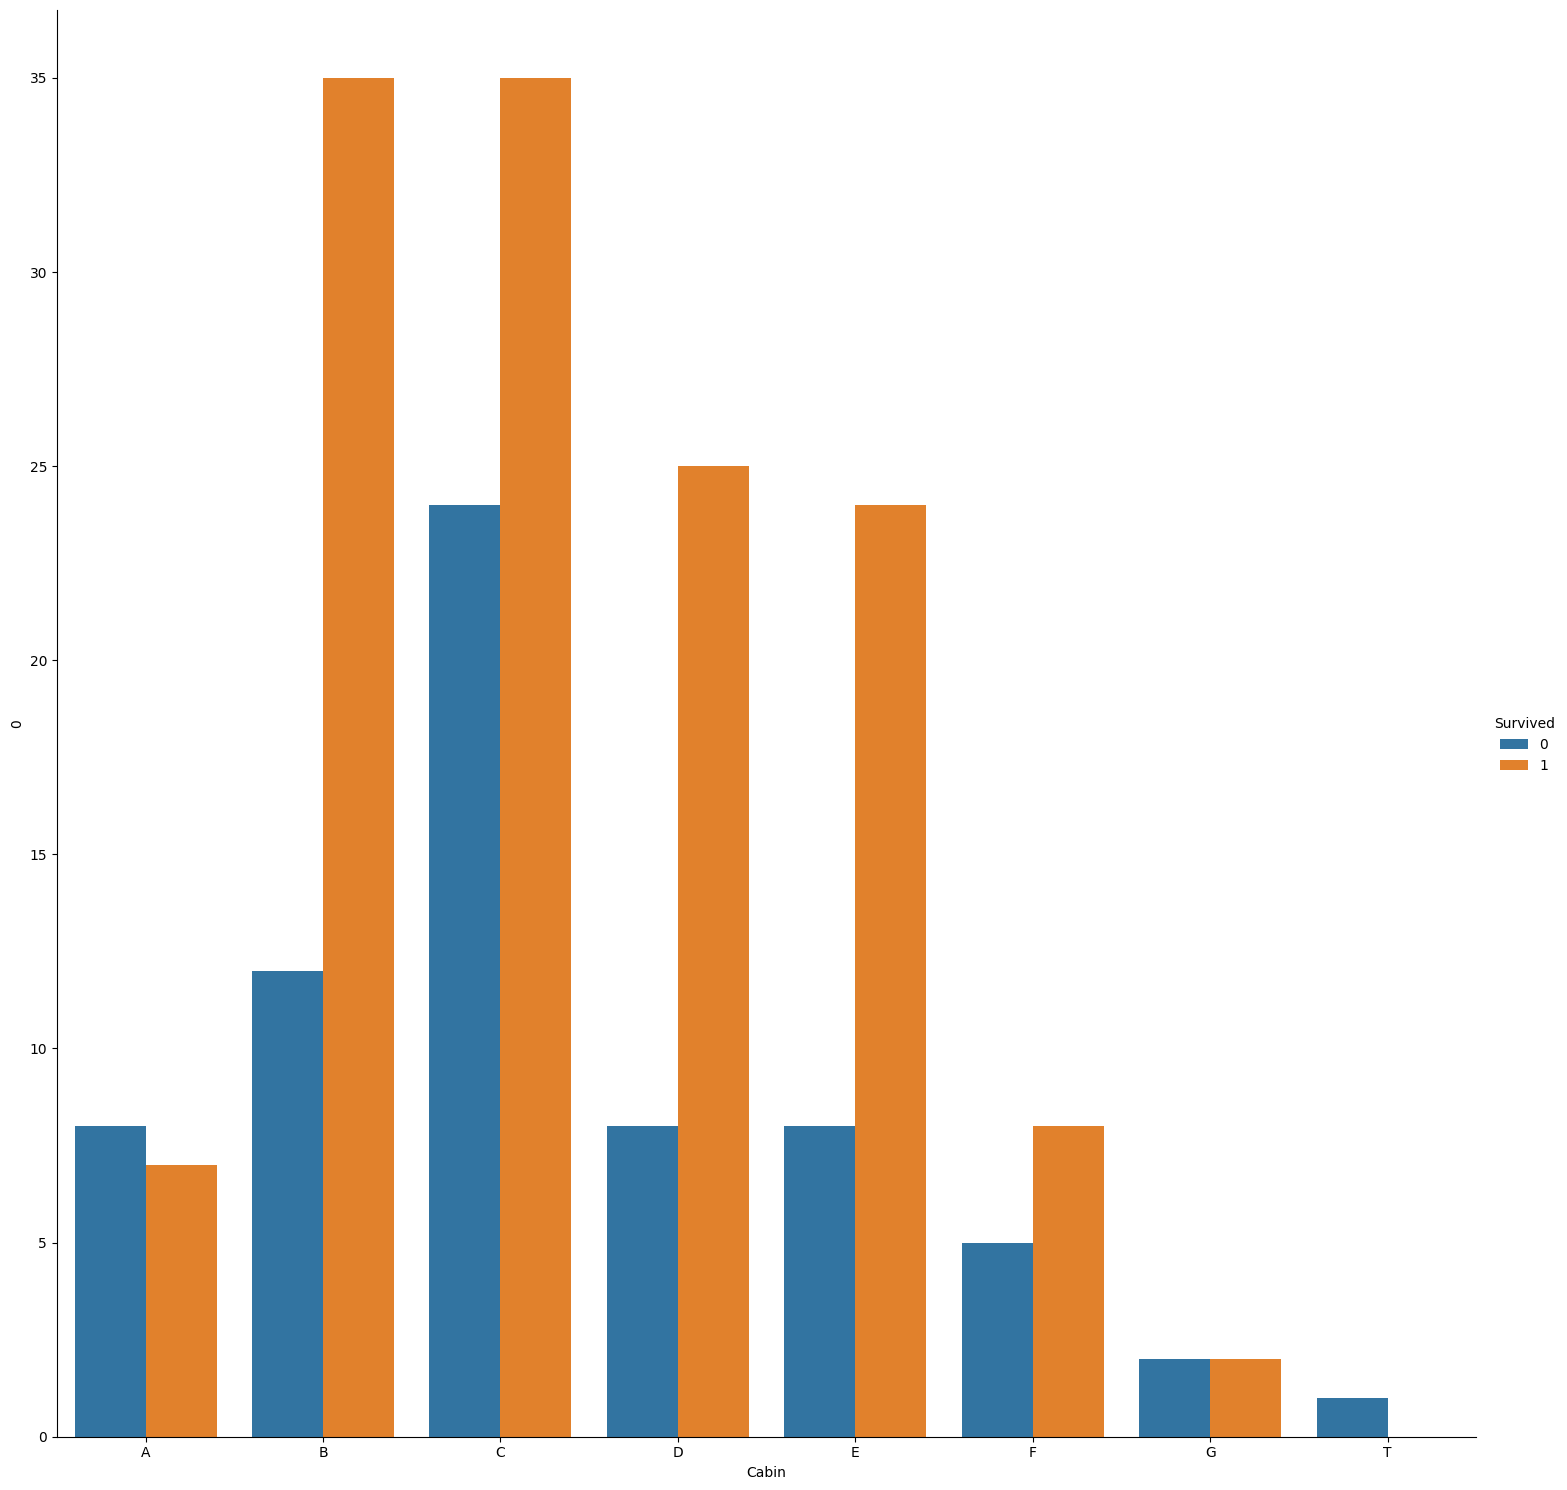

In [59]:
group_cabin = train[["Cabin", "Survived"]].groupby(by="Cabin").value_counts().reset_index()
group_cabin

'''
labels = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "T": 8}
train.loc[:, "Cabin"] = train["Cabin"].apply(lambda x: x if pd.isnull(x) else labels[x[0]])
train["Cabin"].value_counts().sort_index()

corr = train.loc[:, ~train.columns.isin(["PassengerId"])]\
    .select_dtypes(exclude=["object"])\
    .corr()["Survived"]\
    .sort_values(ascending=False)
print(corr["Cabin"])
'''

sns.catplot(
    data=group_cabin,
    x="Cabin",
    y=0,
    hue="Survived",
    kind="bar",
    height=15,
    aspect=1)

### Анализ пола
Очевидна зависимость: мужчины обладают меньшими шансами на выживание (видим, связано с тем, что в первую очередь, спасали женщин и детей)

**Решение**: перезаписать признак *Sex* в номинальные категории $\{0, 1\}$.

/tmp/ipykernel_29152/2068435593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survived_by_sex["Survived"].replace(0, "Death", inplace=True)
/tmp/ipykernel_29152/2068435593.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survived_by_sex["Survived"].replace(1, "Survive", inplace=True)


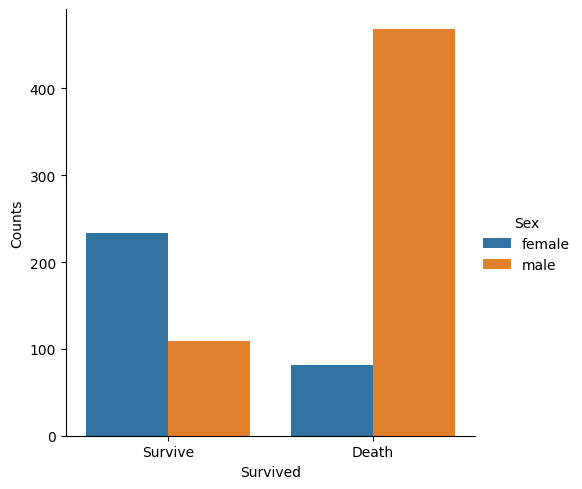

In [28]:
survived_by_sex = train[["Survived", "Sex"]]
survived_by_sex["Survived"].replace(0, "Death", inplace=True)
survived_by_sex["Survived"].replace(1, "Survive", inplace=True)
survived_by_sex = survived_by_sex\
    .groupby(by="Sex")\
    .value_counts()\
    .reset_index()\
    .rename(columns={0: "Counts"})

sns.catplot(
    data=survived_by_sex,
    x="Survived",
    y="Counts",
    hue="Sex",
    kind="bar")